# esperienza contatore geiger
questo è un simulatore di un contatore Geiger.

In [3]:
import numpy as np
import math
import sys
import random
import matplotlib.pyplot as plt


def MisuraConteggi( R,T, n_misure, mode='myMode'):
    # myMode e' una flag che puo' servire a definire il tipo di misura
    # per esempio se faccio una misura di segnale o segnale piu' fonto

    # lo strumento accetta solo tempi al secondo tra 1 e 600
    T = round(T,1)
    ti = 0.001
    if T<1 or T>600:
        print ("La durata di una singola presa dati deve essere un numero tra 1s e 600s")
        sys.exit() 
    
    N_tempi = int(T/ti)
    p_distr=R*T/N_tempi
    # liste per registrare i conteggi e i tempi di ciascun conteggio
    counts_list = []
    time_counts_list = []

    # faccio un loop sul numero di misure
    for mis in range(1,n_misure+1):
        tmp_time_counts_list = []        
        tmp_count = 0
        t_tent = 0
###############################################
### simulo il comportamento di una misura
### qui devo generare in modo corretto i tempi
### a cui avvengo i conteggi
###
        for tempi in range(1,N_tempi+1):
            p=np.random.uniform(0,1,1)
            if p_distr>p:
                hit_time= t_tent
                tmp_count += 1
 
                tmp_time_counts_list.append(hit_time) 

            t_tent = t_tent + ti
### finisco la simulazione di una misura
################################################

        # registro la misura nella lista delle misure
        counts_list.append(tmp_count)
        time_counts_list.append(np.asarray(tmp_time_counts_list))    
### esco dal loop sulle misure
################################################

    # se necessario converto le liste in array
    time_counts_np = np.asarray(time_counts_list)
    counts_np = np.asarray(counts_list)    

       

    return  counts_np, time_counts_np


## misura radiazione di fondo
R = 5 s^-1
si considereranno 50 misure per tempi diversi t=1, 2, 3, 4, 10, 599 s

In [4]:
R=5
T1=1
T2=2
T3=3
T4=4
T5=10
T6=599
conteggi_t1,risultati_t1=MisuraConteggi( R ,T=1, n_misure=70, mode='myMode')

In [5]:
conteggi_t2,risultati_t2=MisuraConteggi( R ,T=2, n_misure=70, mode='myMode')

In [6]:
conteggi_t3,risultati_t3=MisuraConteggi( R ,T=3, n_misure=70, mode='myMode')

In [7]:
conteggi_t4,risultati_t4=MisuraConteggi( R ,T=4, n_misure=70, mode='myMode')

In [8]:
conteggi_t10,risultati_t10=MisuraConteggi( R ,T=10, n_misure=70, mode='myMode')

In [9]:
conteggi_t599,risultati_t599=MisuraConteggi( R ,T=599, n_misure=70, mode='myMode')

In [10]:
def istogrammi_tentativi(R,T,conteggi,off,bin):
    #istogramma
    l=R*T
    mean=l
    sd=np.sqrt(l)
    plt.hist(conteggi,density=True,bins=bin)
    #funzione
    from scipy.stats import poisson
    
    p=poisson(mu=l)
    x = np.arange(l-3*int(sd),l+3*int(sd))
    plt.plot(x, p.pmf(x), 'bo', ms=4,label='poisson pmf $\lambda$={0:.1f}'.format(l))
    #media e deviazione standard
    plt.hlines(off, mean-sd, mean+sd,
           colors='black', lw=2, label='media $\pm \sigma$')
    plt.plot(mean, off, 'ro', ms=8, label='media')
    plt.title('Istogramma tentativi t={0:.1f}s'.format(T),  fontsize=16)
    plt.xlabel("x", fontsize=16)
    plt.ylabel("probabilità $P(x| P_{\lambda})$", fontsize=16)
    plt.legend( fontsize=10)
    plt.ylim(0, np.max(p.pmf(x))*2)

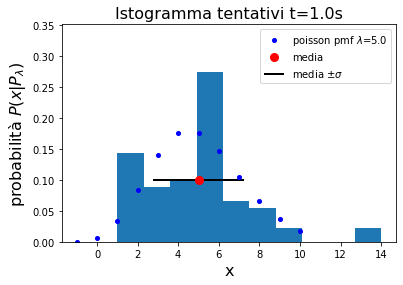

In [11]:
istogrammi_tentativi(R,T1,conteggi_t1,0.1,10)

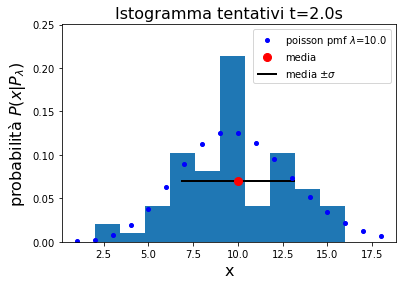

In [12]:
istogrammi_tentativi(R,T2,conteggi_t2,0.07,10)

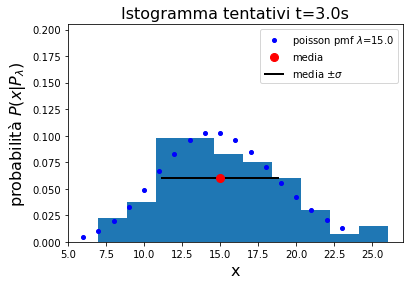

In [13]:
istogrammi_tentativi(R,T3,conteggi_t3,0.06,10)

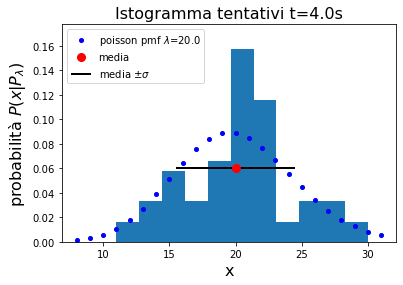

In [14]:
istogrammi_tentativi(R,T4,conteggi_t4,0.06,11)

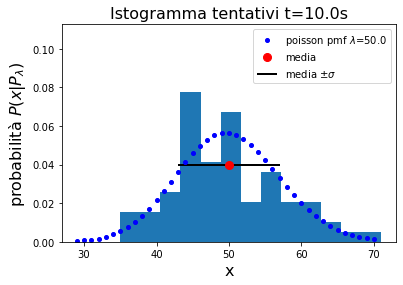

In [15]:
istogrammi_tentativi(R,T5,conteggi_t10,0.04,13)

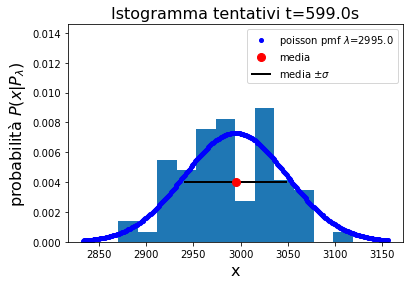

In [16]:
istogrammi_tentativi(R,T6,conteggi_t599,0.004,12)

## inferenza su lamda
prima inferisco e mi trovo la lamda per ogni tempo con la sua incertezza. Per trovare il rate di ogni tempo prendo semplicemente lamda e la divido per t. Per l'inferenza si utilizza la funzione gamma per una combinazione lineare sul numero di conteggi

In [17]:
from scipy.stats import gamma

def inferenza_lamda(conteggi,n_mis,off,T,xlim1,xlim2):
    x=sum(conteggi)
    l = np.linspace(xlim1, xlim2, 300)
    plt.plot(l, gamma.pdf(l, a=x+1, scale=1/n_mis),
             label='$f(\lambda|~\sum x_i=${0:.1f})'.format(x))
    plt.title('Funzione posterior Poissoniana t=={0:.1f}s '.format(T), fontsize=16)
    plt.xlabel('$\lambda$',fontsize=16)
    plt.ylim(0, 1.5*max(gamma.pdf(l, a=x+1, scale=1/n_mis)))
    plt.ylabel('$f(\lambda)$',fontsize=16)
    plt.legend(loc='upper right',fontsize=16)
    mean, var = gamma.stats(a=x+1, scale=1/n_mis, moments='mv')
    sd = np.sqrt(var)
    plt.hlines(off, mean-sd, mean+sd,
               colors='black', lw=2,
               label='$\sigma[\lambda]=${0:.2f}'.format(sd))
    plt.plot(mean, off, 'ro', ms=8,
             label='E[$\lambda$]={0:.2f}'.format(mean))
    plt.legend(loc='upper right',fontsize=11)
    return mean,sd

(array(4.91428571), 0.2649605284427344)

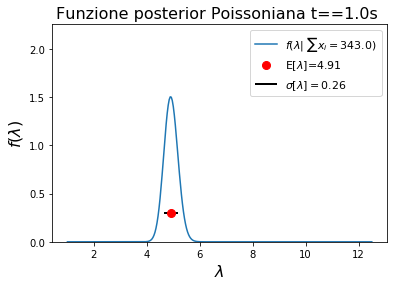

In [18]:
inferenza_lamda(conteggi_t1,70,0.3,T1,1,12.5)

(array(9.71428571), 0.37252585172586566)

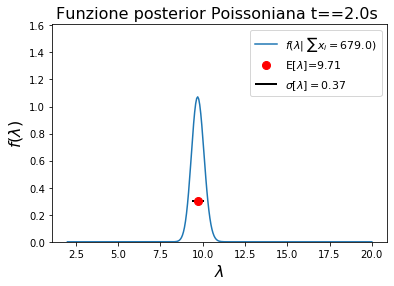

In [19]:
inferenza_lamda(conteggi_t2,70,0.3,T2,2,20)

(array(15.18571429), 0.46576686819717444)

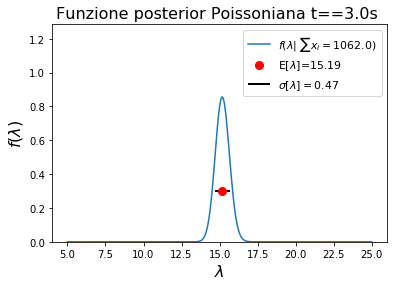

In [20]:
inferenza_lamda(conteggi_t3,70,0.3,T3,5,25)

(array(20.32857143), 0.5388953175388576)

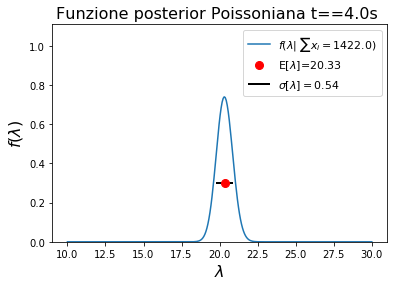

In [21]:
inferenza_lamda(conteggi_t4,70,0.3,T4,10,30)

(array(49.95714286), 0.8447919681127154)

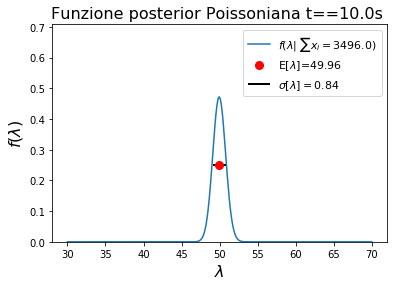

In [22]:
inferenza_lamda(conteggi_t10,70,0.25,T5,30,70)

(array(2987.24285714), 6.532602694116923)

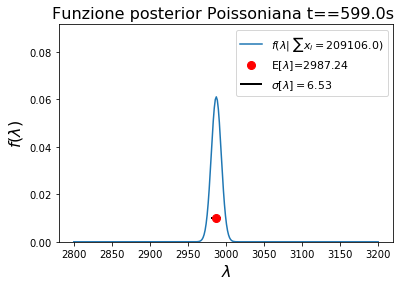

In [23]:
inferenza_lamda(conteggi_t599,70,0.01,T6,2800,3200)

per trovare il valore Rbest con relativa incertezza un metodo potrebbe essere la media pesata sui tempi. Non sono sicuro, correggetemi se sbaglio. ATTENZIONE! I DATI SONO QUELLI DEGLI ISTOGRAMMI PASSATI, IN FOTO.

 RT(tot) = R1*T1 + R2*T2 +...+Rn*Tn = lamda1 + ... + lamda.n

In [27]:
mylamdas = [5.32,9.70,15.46,19.77,51.17,3007.74]
my_sigma_lamdas = [0.28,0.37,0.47,0.53,0.85,6.55]
mylamdas=np.array(mylamdas)
my_sigma_lamdas=np.array(my_sigma_lamdas)

In [29]:
mu_Rbest=sum(mylamdas)/(1+2+3+4+10+599)

In [36]:
sigma_Rbest= np.sqrt(sum(pow(my_sigma_lamdas,2)))/(1+2+3+4+10+599)

In [37]:
mu_Rbest,sigma_Rbest

(5.022875605815832, 0.010757651711400496)